In [ ]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=0b863a85694ab48bcb948a4ff3c6e3f223ee5931f94acd14b2fae20352dfd50f
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord
     |████████████████████████████████| 11.8 MB 3.8 MB/s 
no display found. Using non-interactive Agg backend


In [ ]:
delays = pd.read_csv('FlightDelays.csv')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
delays.DAY_WEEK = delays.DAY_WEEK.astype('category')
delays.CRS_DEP_TIME = [round(t/100) for t in delays.CRS_DEP_TIME]
delays.CRS_DEP_TIME = delays.CRS_DEP_TIME.astype('category')
delays.DAY_WEEK = delays.DAY_WEEK.astype('category')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
delays['isdelayed'] = [1 if a == 'delayed' else 0 for a in delays['Flight Status']]

In [ ]:
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isdelayed
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0


In [ ]:
predictors = ['CRS_DEP_TIME','DAY_WEEK','ORIGIN','DEST','CARRIER']
outcome = 'isdelayed'

X = pd.get_dummies(delays[predictors],drop_first=True)
y = delays[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4,random_state=1)

split /
declare model /
fit model /
predictions /
probabilities /
data frame of predictions /
confusion matrix /
gains chart

In [ ]:
log_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
log_reg.fit(train_X,train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
print('intercept',log_reg.intercept_)

intercept [-1.11680634]


In [ ]:
print(pd.DataFrame({'coef':log_reg.coef_[0],
                    'odds':np.e**log_reg.coef_[0]},
                   index=X.columns))

                     coef      odds
CRS_DEP_TIME_7   0.619965  1.858863
CRS_DEP_TIME_8   0.384634  1.469077
CRS_DEP_TIME_9  -0.168302  0.845099
CRS_DEP_TIME_10  0.439087  1.551290
CRS_DEP_TIME_11  0.055248  1.056803
CRS_DEP_TIME_12  0.485043  1.624245
CRS_DEP_TIME_13  0.183348  1.201233
CRS_DEP_TIME_14  0.329139  1.389771
CRS_DEP_TIME_15  1.319538  3.741692
CRS_DEP_TIME_16  0.667728  1.949802
CRS_DEP_TIME_17  1.121528  3.069540
CRS_DEP_TIME_18  0.277080  1.319272
CRS_DEP_TIME_19  1.680137  5.366292
CRS_DEP_TIME_20  1.009472  2.744153
CRS_DEP_TIME_21  1.133060  3.105144
DAY_WEEK_2      -0.480597  0.618414
DAY_WEEK_3      -0.791871  0.452997
DAY_WEEK_4      -0.890501  0.410450
DAY_WEEK_5      -0.385297  0.680249
DAY_WEEK_6      -1.214981  0.296716
DAY_WEEK_7      -0.188653  0.828074
ORIGIN_DCA      -0.100889  0.904033
ORIGIN_IAD      -0.174114  0.840201
DEST_JFK        -0.448727  0.638440
DEST_LGA        -0.464066  0.628722
CARRIER_DH       0.286247  1.331422
CARRIER_DL      -0.708458  0

odds大于1，比如departure time@7 85.8% more likely to be delayed than flight takes off at 6(compared to the value that has been excluded), 如果小于1， 比如@9，不代表提前了，just earlier than the flight takes off at 6 flight takes off, it is 13.5% less likely to be delayed than flight takes off at 6 because it is less than 1.

if the flight depart 15, it is 274% more likely to take off late than the flight takes off at 6 / this plane is 3.7 more times more likely to be late

In [ ]:
log_reg_prob = log_reg.predict_proba(valid_X)
log_reg_pred = log_reg.predict(valid_X)

In [ ]:
log_result = pd.DataFrame({'actual':valid_y,
                           'predicted':log_reg_pred,
                            'p_0_ontime':[p[0] for p in log_reg_prob],
                            'p_1_delayed':[p[1] for p in log_reg_prob]
                             })
log_result

,actual,predicted,p_0_ontime,p_1_delayed
1276,0,0,0.686901,0.313099
1446,0,0,0.960155,0.039845
335,0,0,0.805467,0.194533
1458,0,0,0.948094,0.051906
2038,0,0,0.966451,0.033549
...,...,...,...,...
460,0,0,0.812663,0.187337
2063,0,0,0.903135,0.096865
159,0,0,0.824281,0.175719
2027,1,0,0.953369,0.046631


In [ ]:
classes = ['ontime','delayed']
classificationSummary(log_result.actual,log_result.predicted, class_names=classes)

Confusion Matrix (Accuracy 0.8093)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     159       8


In [ ]:
df = log_result.sort_values(by='p_1_delayed',ascending=False)
df

,actual,predicted,p_0_ontime,p_1_delayed
264,1,1,0.326386,0.673614
724,0,1,0.369136,0.630864
1328,0,1,0.386407,0.613593
1850,1,1,0.386407,0.613593
825,0,1,0.386407,0.613593
...,...,...,...,...
1561,0,0,0.974362,0.025638
434,0,0,0.976046,0.023954
1051,1,0,0.978247,0.021753
140,0,0,0.980294,0.019706


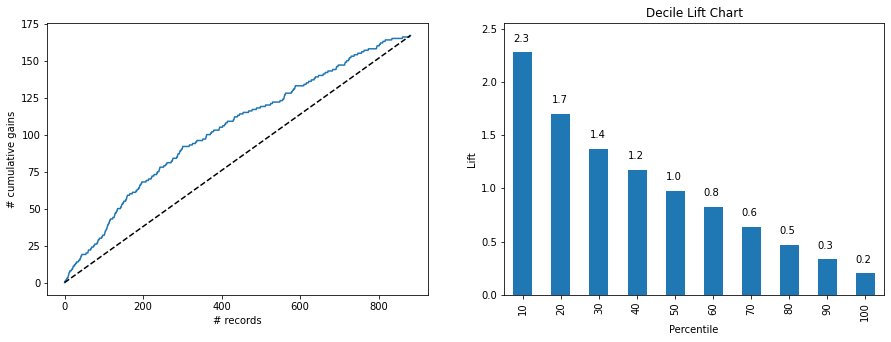

In [ ]:
fig, axes = plt.subplots(1,2, figsize=[15,5])
gainsChart(df.actual,ax=axes[0])
liftChart(df['p_1_delayed'],ax=axes[1])

we can take action on 200 flights that are most likely to be delayed. (It means 70 targets covered in the top 200 data based on the model).

https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14


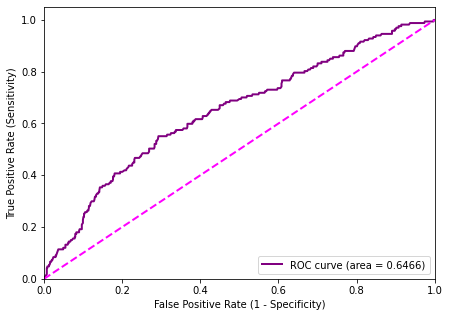

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(df['actual'], df['p_1_delayed']) 
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[7, 5]) 
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='magenta', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)') 
plt.legend(loc="lower right")